# Анализ данных об оттоке клиентов некоторого банка

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.express as px

In [2]:
churn_data = pd.read_csv('Data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Предобработка данных

In [3]:
churn_df = churn_data.drop('RowNumber', axis=1)

Проанализируем количество уникальных данных в столбцах и определим их тип

In [4]:
# Определим функцию для определения количества уникальных значений и типа
def unique_types(df):
    unique_list = []
    for col in df.columns:
        item = (col, df[col].nunique(), df[col].dtype)
        unique_list.append(item)
    unique_df = pd.DataFrame(
        unique_list,
        columns=['Column_names','Unique_count','Type']
    ).sort_values(by='Unique_count', ignore_index=True)
    return unique_df

In [5]:
display(unique_types(churn_df))

,Column_names,Unique_count,Type
0,Gender,2,object
1,HasCrCard,2,int64
2,IsActiveMember,2,int64
3,Exited,2,int64
4,Geography,3,object
5,NumOfProducts,4,int64
6,Tenure,11,int64
7,Age,70,int64
8,CreditScore,460,int64
9,Surname,2932,object


Добавим признак категорий столбцам:
- Gender
- Geography

In [6]:
category_list = ['Gender','Geography']
for item in category_list:
    churn_df[item] = churn_df[item].astype('category')

Прокатегорируем клиентов по возрасту согласно ВОЗ

In [7]:
#Определим функцию категорирования
def age_to_category(col):
    age_cat = {'young':45,'middle':60,'older':75,'elderly':90,'long_lived':200} #словарь категорий
    for elem in age_cat.keys():
        if col < age_cat[elem]: # проверка на первое соответствие
            result = elem
            break #прерываем после первого вхождения в условие
        
    return result

In [8]:
#Применим apply функцию категорирования
churn_df['Age_Category'] = churn_df['Age'].apply(age_to_category)

Добавим столбец с наименованием действуюещго статуса клиента

In [9]:
churn_df['ExitedStatus'] = churn_df['Exited'].apply(lambda x: 'loyal' if x== 0 else 'left').astype('category')

Добавим столбец с наименованием статуса активного клиента

In [10]:
churn_df['ActiveMemberStatus'] = churn_df['IsActiveMember'].apply(lambda x: 'Active' if x==1 else 'Non_active').astype('category')

___

## <center> 1. Определим соотношение ушедших и лояльных клиентов.

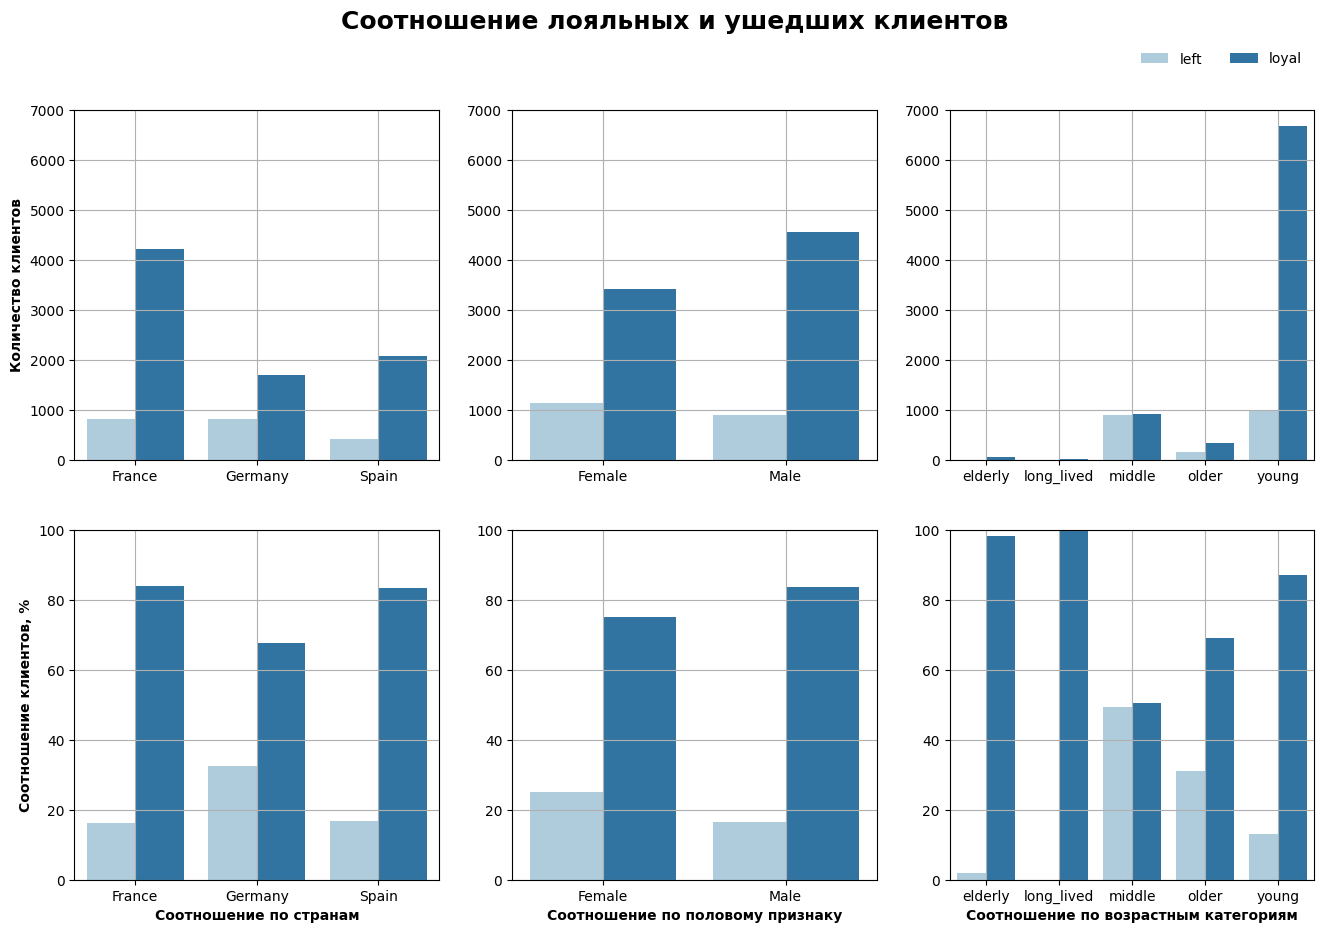

In [11]:
#Создадим Series с процетным соотношением по странам
geography_data = churn_df.groupby(['Geography','ExitedStatus'], as_index= True)['CustomerId'].count()/(
    churn_df.groupby(['Geography'], as_index= True)['Exited'].count()
)*100

#Создадим Series с процетным соотношением по гендеру
gender_data = churn_df.groupby(['Gender','ExitedStatus'], as_index= True)['CustomerId'].count()/(
    churn_df.groupby(['Gender'], as_index= True)['Exited'].count()
)*100

#Создадим Series с процетным соотношением по возрастным категориям
age_category_data = churn_df.groupby(['Age_Category','ExitedStatus'], as_index= True)['CustomerId'].count()/(
    churn_df.groupby(['Age_Category'], as_index= True)['Exited'].count()
)*100


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10))

#Нарисуем столбчатую диаграмму зависимости от географического расположения
sns.barplot(
    data = churn_df.groupby(['Geography','ExitedStatus'], as_index= False)['CustomerId'].count(),
    x= 'Geography',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[0,0]
)
axes[0,0].grid()
axes[0,0].set_ylim(0,7000)
axes[0,0].set_ylabel(None)
axes[0,0].set_xlabel(None)


#Нарисуем столбчатую диаграмму зависимости от пола
sns.barplot(
    data = churn_df.groupby(['Gender','ExitedStatus'], as_index= False)['CustomerId'].count(),
    x= 'Gender',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[0,1],   
    legend=False
)
axes[0,1].grid()
axes[0,1].set_ylim(0,7000)
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel(None)

#Нарисуем столбчатую диаграмму зависимости от возраста
sns.barplot(
    data= churn_df.groupby(['Age_Category','ExitedStatus'], as_index= False)['CustomerId'].count(),
    x= 'Age_Category',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[0, 2],
    legend=False 
)
axes[0,2].grid()
axes[0,2].set_ylim(0,7000)
axes[0,2].set_ylabel(None)
axes[0,2].set_xlabel(None)

#Нарисуем столбчатую диаграмму зависимости от географического расположения,%
sns.barplot(
    data = geography_data.reset_index(name='CustomerId'),
    x= 'Geography',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[1,0],
    legend= False
)
axes[1,0].grid()
axes[1,0].set_ylim(0,100)
axes[1,0].set_ylabel(None)

#Нарисуем столбчатую диаграмму зависимости от пола,%
sns.barplot(
    data = gender_data.reset_index(name='CustomerId'),
    x= 'Gender',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[1,1],   
    legend=False
)
axes[1,1].grid()
axes[1,1].set_ylim(0,100)
axes[1,1].set_ylabel(None)


#Нарисуем столбчатую диаграмму зависимости от возраста,%
sns.barplot(
    data= age_category_data.reset_index(name='CustomerId'),
    x= 'Age_Category',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[1,2],
    legend=False
)
axes[1,2].grid()
axes[1,2].set_ylim(0,100)
axes[1,2].set_ylabel(None)


# Установим параметры графика (подписи осей, сетку, наименование)
axes[0,0].set_ylabel('Количество клиентов', fontweight='bold')
axes[1,0].set_ylabel('Соотношение клиентов, %', fontweight='bold')

axes[1,0].set_xlabel('Соотношение по странам', fontweight='bold')
axes[1,1].set_xlabel('Соотношение по половому признаку', fontweight='bold')
axes[1,2].set_xlabel('Соотношение по возрастным категориям', fontweight='bold')

fig.suptitle('Соотношение лояльных и ушедших клиентов',fontsize=18, fontweight='bold')
handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,0].get_legend().remove()

fig.legend(handles=handles,labels=labels, title=None, bbox_to_anchor=(0.9,0.95), ncol=2, frameon=False);

Из полученной диаграммы можно сделать несколько выводов:
- Филиал во __Франции__ показывает __наилучшие показатели__ по соотношению лояльных клиентов к ушедшим;
- __Наиболее остро проблема__ оттока клиентов наблюдается в __Германии__;
- Среди всех клиентов банка __наибольший отток клиентов__ наблюдается среди __женщин__;
- __Наибольший процент оттока__ наблюдается у клиентов в возрасте __от 45 до 60 лет__ (middle);
- _Учитывая количество клиентов_, __наибольшей лояльностью__ банк пользуется у клиентов __до 45 лет__ (young).

___

## <center> 2. Посмотрим распределение баланса пользователей, у которых на счету больше 2 500 долларов.

Отфильтруем данным по клиентам, у которых более 2500$ на счету

In [12]:
croped_churn = churn_df[churn_df['Balance']>2500]

Построим графики распределения пользователей по обозначенным категориям:
- 'Geography'
- 'Gender'
- 'Age_Category'

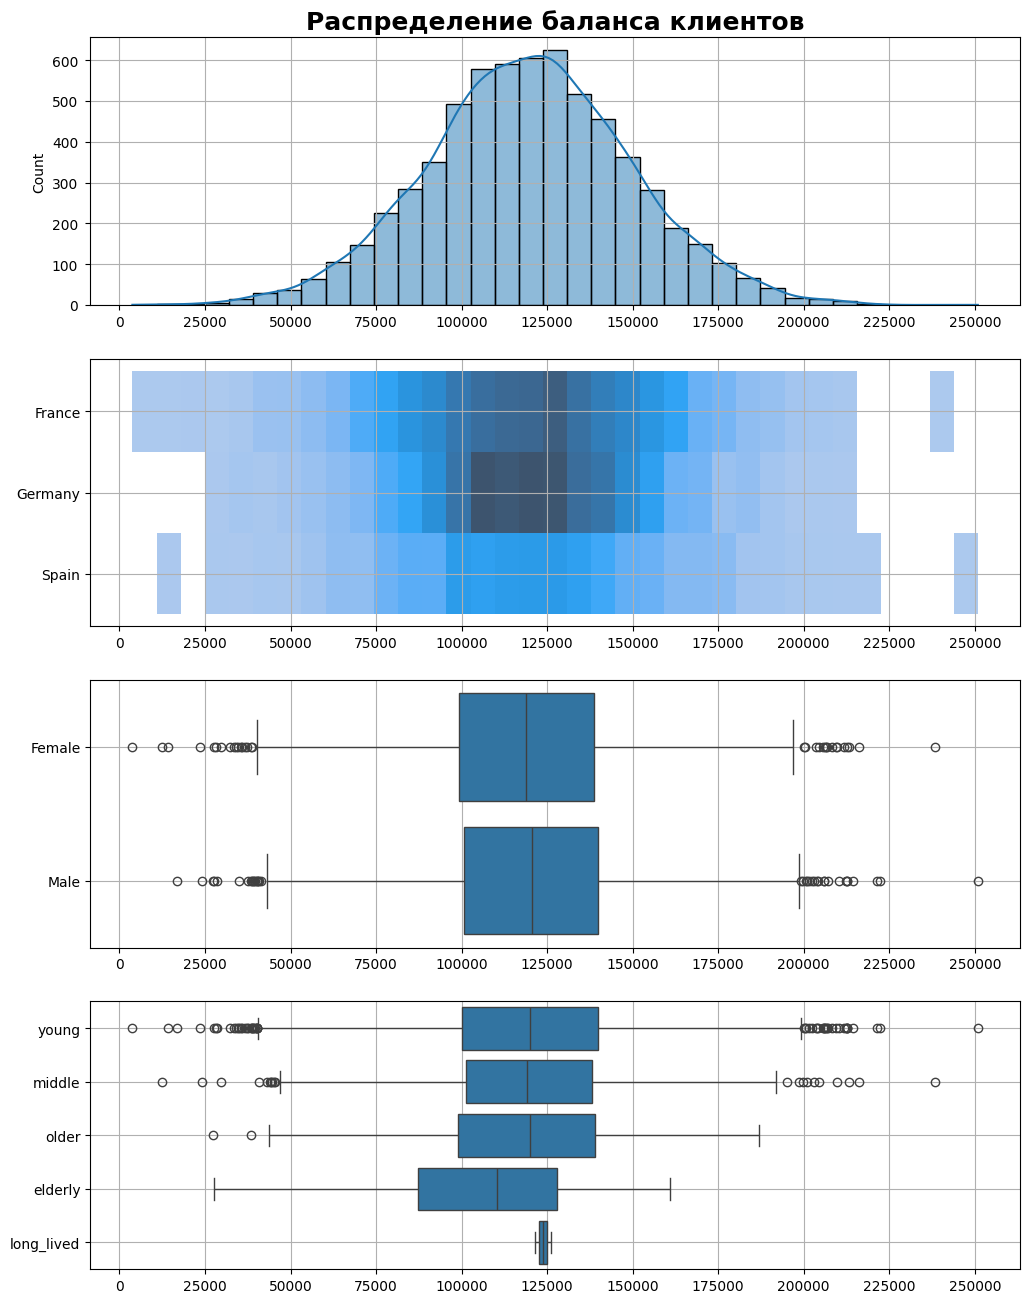

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,16), sharex= False)
sns.histplot(
    data = croped_churn,
    x = "Balance",
    bins = 35,
    ax = axes[0],
    kde= True,
)
axes[0].grid()
axes[0].tick_params(axis='y', pad=5)
axes[0].xaxis.set_major_locator(MultipleLocator(25000))
axes[0].set_xlabel(None)


sns.histplot(
    data = croped_churn,
    x = "Balance",
    y= 'Geography',
    bins = 35,
    ax = axes[1],
    #color='blue'
)
axes[1].grid()
axes[1].set_ylabel(None)
axes[1].xaxis.set_major_locator(MultipleLocator(25000))
axes[1].set_xlabel(None)


sns.boxplot(
    data = croped_churn,
    x = "Balance",
    y= 'Gender',
    #bins = 30,
    ax = axes[2],
    #color='blue'
)
axes[2].grid()
axes[2].set_ylabel(None)
axes[2].xaxis.set_major_locator(MultipleLocator(25000))
axes[2].set_xlabel(None)



sns.boxplot(
    data = croped_churn,
    x = "Balance",
    y= 'Age_Category',
    #hue= 'Age_Category',
    ax = axes[3],
    #palette='dark'
)
axes[3].grid()
axes[3].set_ylabel(None)
axes[3].xaxis.set_major_locator(MultipleLocator(25000))
axes[3].set_xlabel(None)

axes[0].set_title('Распределение баланса клиентов',fontsize=18, fontweight='bold');

#fig.suptitle('Распределение баланса клиентов',fontsize=18, fontweight='bold');

Из полученных графиков видно, что:
- Большинство клиентов банка хранит на счету **от 90 до 130 тыс.$**;
- Больше всего клиентов хранят деньги в филале в __Германии__;
- Суммы вкладов в среднем __распределены одинаково__ между мужчинами и женщинами. У мужчин средняя сумма вклада лишь на пару тысяч больше, чем у женщин;
- Молодое и пожилое поколение имеют имеют __средний счет выше__, чем у среднего поколения и людей преклонного возраста.

___

## <center> 3. Построим график распределение баланса клиентов в разрезе оттока клиентов.

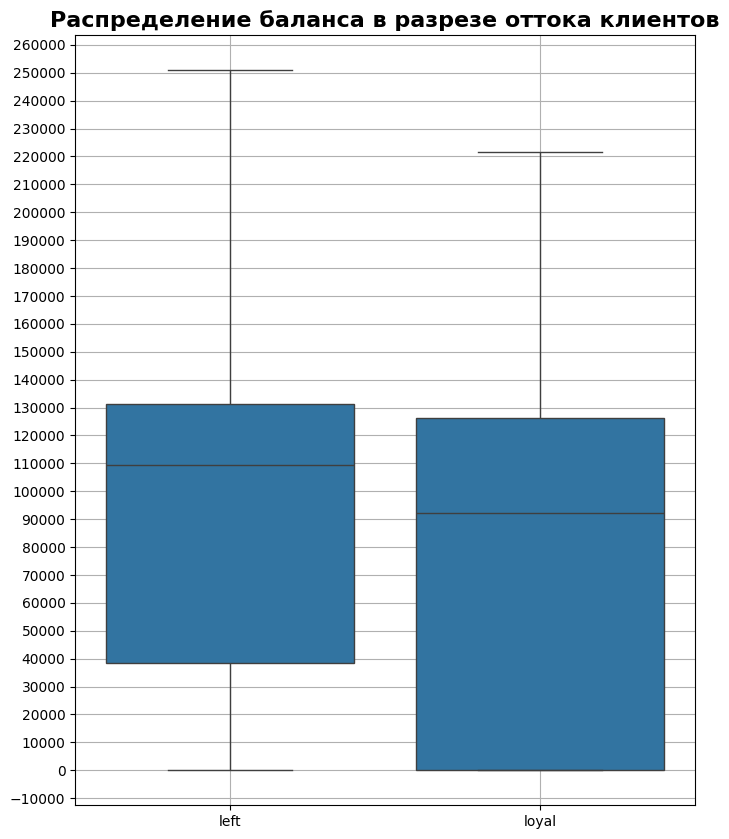

In [14]:
fig = plt.figure(figsize=(8,10))
balance_exited = sns.boxplot(
    data= churn_df,
    y= 'Balance',
    x= 'ExitedStatus',
    orient='v',
)
balance_exited.grid()
balance_exited.set_title('Распределение баланса в разрезе оттока клиентов', fontweight='bold', fontsize=16)
balance_exited.set_xlabel(None)
balance_exited.set_ylabel(None)
balance_exited.yaxis.set_major_locator(MultipleLocator(10000));

На представленном графике видно, что у __ушедиших__ клиентов на балнсе было __больше средств__, чем у лояльных.
Это может быть связано с более привлекательными условиями у конкурентов. Рекомендуется рассмотреть более выгодную программу и бонусы, зависящую от баланса клиента

___

## <center> 4. Построим график распределение возраста клиентов в разрезе оттока клиентов.

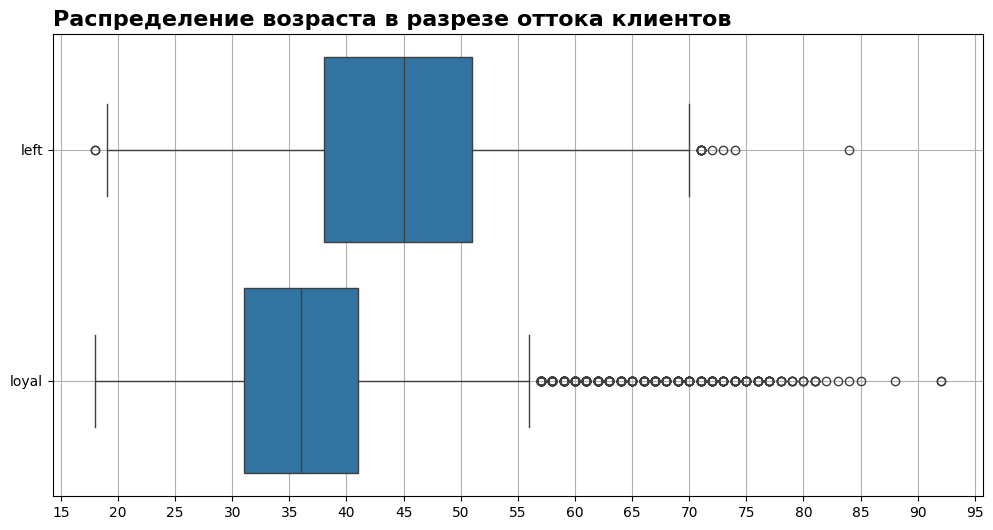

In [15]:
fig = plt.figure(figsize=(12,6))
balance_exited = sns.boxplot(
    data= churn_df,
    x= 'Age',
    y= 'ExitedStatus',
    orient='h'
)
balance_exited.grid()
balance_exited.set_title('Распределение возраста в разрезе оттока клиентов', 
                         fontweight='bold', 
                         fontsize=16,
                         loc='left')
balance_exited.set_xlabel(None)
balance_exited.set_ylabel(None);
balance_exited.xaxis.set_major_locator(MultipleLocator(5));

В соответствии с полученным распределением можно сделать вывод, что __наибольший отток__ клиентов наблюдается в возрасте от __38 лет до 51 года__. Наибольшее количество потенциальных выбросов наблюдается среди лояльных клиентов от 56 лет.

___

## <center> 5. Построим график взаимосвязи кредитного рейтинга и его предполагаемой зарплаты.

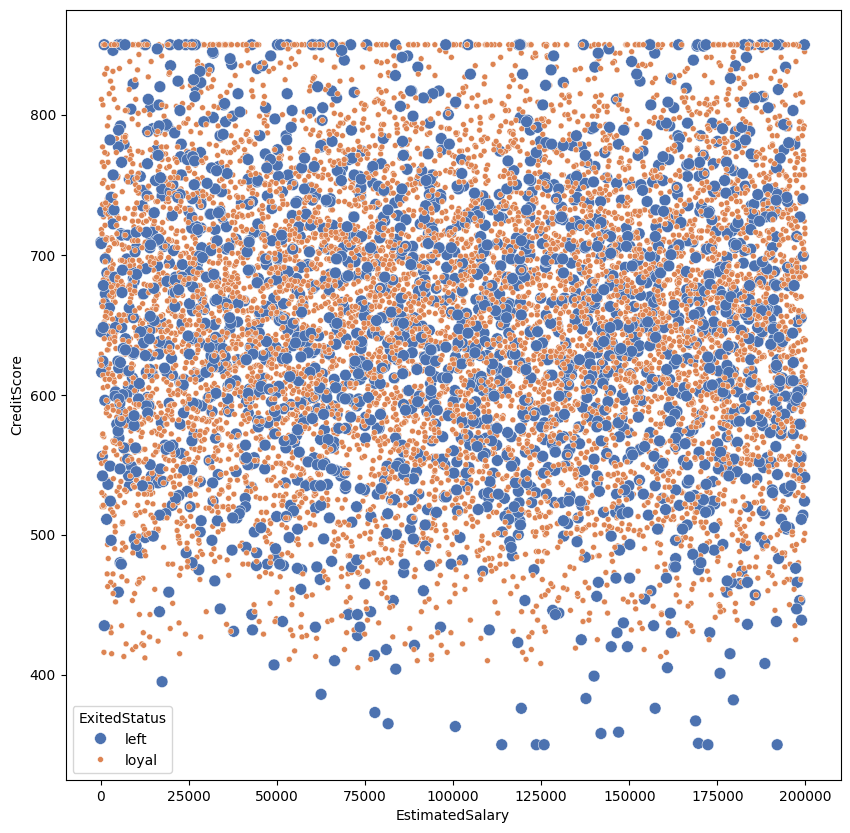

In [16]:
fig = plt.figure(figsize=(10,10))
scat = sns.scatterplot(
    data=churn_df,
    x= 'EstimatedSalary',
    y= 'CreditScore',
    hue= 'ExitedStatus',
    palette= 'deep',
    size= 'ExitedStatus'
)
scat.get_label();

Без дополнительной обработки определить взаимосвязь по полученному графику не представляется возможным

___

## <center> 6. Построим график взаимосвязи оттока клиентов по половому признаку.

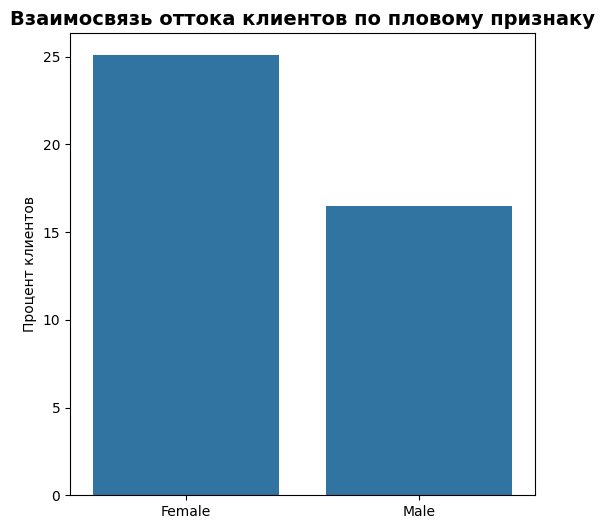

In [17]:
fig = plt.figure(figsize=(6,6))
gender_exit = sns.barplot(
    data= churn_df.groupby(by= 'Gender')['Exited'].mean()*100,    
)
gender_exit.set_title('Взаимосвязь оттока клиентов по пловому признаку',
                      fontweight = 'bold',
                      fontsize= 14)
gender_exit.set_xlabel(None)
gender_exit.set_ylabel('Процент клиентов');

Наибольший процент оттока клиентов наблюдается у __женщин__.

___

## <center> 7. Построим график взаимосвязи оттока клиентов от числа приобретенных услуг.

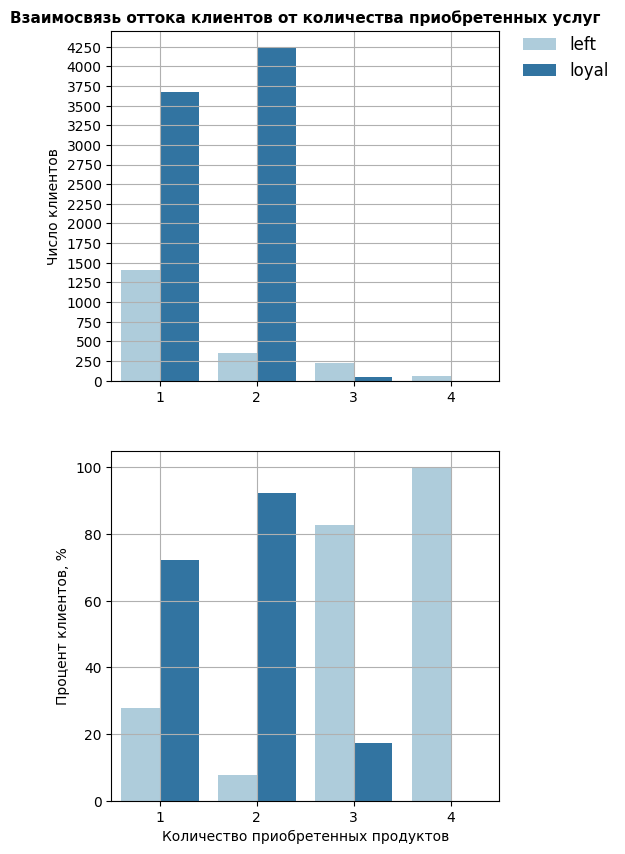

In [18]:
# создадим Series процентного соотношения количества клиентов 
# с разбивкой по статусу лояльности к количеству приобретенных продуктов

num_prod = churn_df.groupby(by= ['NumOfProducts','ExitedStatus'], as_index= True)['CustomerId'].count()/(
    churn_df.groupby(['NumOfProducts'], as_index= True)['Exited'].count()
)*100


fig, axes= plt.subplots(nrows= 2, ncols= 1, figsize=(5,10), sharex= False)
bar_prod_count= sns.barplot(
    data= churn_df.groupby(by= ['NumOfProducts','ExitedStatus'], as_index= False)['CustomerId'].count(),
    x= 'NumOfProducts',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[0]
)
bar_prod_count.grid()
bar_prod_count.set_ylabel('Число клиентов')
bar_prod_count.set_xlabel(None)
bar_prod_count.set_title('Взаимосвязь оттока клиентов от количества приобретенных услуг',
                         fontweight= 'bold',
                         fontsize= 11)
bar_prod_count.yaxis.set_major_locator(MultipleLocator(250))

bar_prod_percent= sns.barplot(
    data= num_prod.reset_index(name='CustomerId'), #обнуляем индексы
    x= 'NumOfProducts',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[1]
)
bar_prod_percent.grid()
bar_prod_percent.set_ylabel('Процент клиентов, %')
bar_prod_percent.get_legend().remove()
bar_prod_percent.set_xlabel('Количество приобретенных продуктов')

#Получим данные легенды из первого графика
handles, labels = bar_prod_count.get_legend_handles_labels()
#Удалим легенду в первом графике
bar_prod_count.get_legend().remove()
#Приклеим легенду к фигуре
fig.legend(handles=handles,labels=labels, title=None,  bbox_to_anchor=(1.15,0.89), frameon=False, fontsize= 12);

Порядка 50-ти клиентов приобрели 4 продукта банка, порядка 300 человек приобрели 3 продукта. Учитывая процент данных клиентов от общего количества банка сфокусировать внимание требуется на клиентах, которые пользуются 1-2-мя продуктами.\
Наибольший процент лояльных клиентов наблюдается у тех, кто пользуется 2-мя услугами (2 группа).\
Возможно требуется рассмотреть некоторую программу лояльности, внедрить дополнительные продукты банка для увеличения заинтересованности клиентов. 

___

## <center> 8. Построим график взаимосвязи оттока клиентов от статуса активного клиента.

Для лучшего понимания пострим два сабплота (количественное и процентное соотношение)

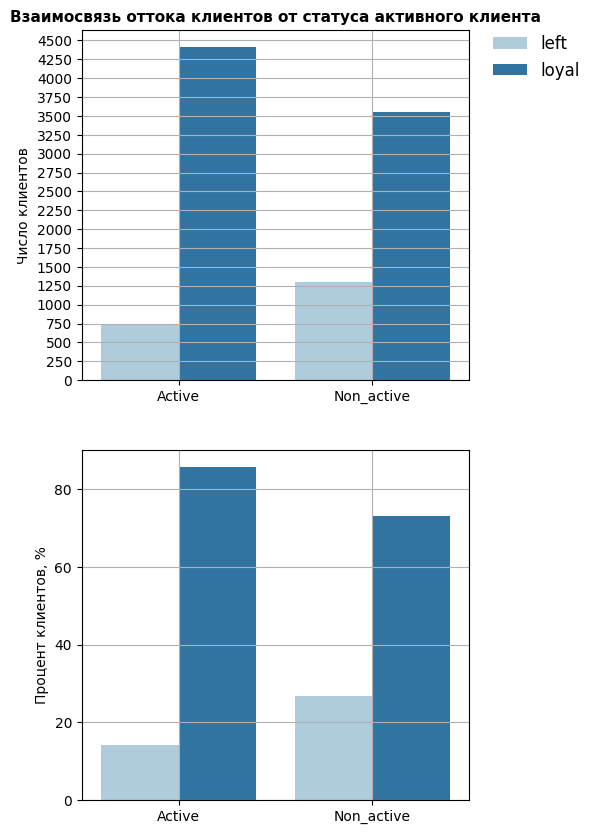

In [19]:
# создадим Series процентного соотношения количества клиентов 
# с разбивкой по статусу лояльности к количеству приобретенных продуктов

active_member = churn_df.groupby(by= ['ActiveMemberStatus','ExitedStatus'], as_index= True)['CustomerId'].count()/(
    churn_df.groupby(['ActiveMemberStatus'], as_index= True)['Exited'].count()
)*100


fig, axes= plt.subplots(nrows= 2, ncols= 1, figsize=(5,10), sharex= False)
bar_prod_count= sns.barplot(
    data= churn_df.groupby(by= ['ActiveMemberStatus','ExitedStatus'], as_index= False)['CustomerId'].count(),
    x= 'ActiveMemberStatus',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[0]
)
bar_prod_count.grid()
bar_prod_count.set_ylabel('Число клиентов')
bar_prod_count.set_xlabel(None)
bar_prod_count.set_title('Взаимосвязь оттока клиентов от статуса активного клиента',
                         fontweight= 'bold',
                         fontsize= 11)
bar_prod_count.yaxis.set_major_locator(MultipleLocator(250))

bar_prod_percent= sns.barplot(
    data= active_member.reset_index(name='CustomerId'), #обнуляем индексы
    x= 'ActiveMemberStatus',
    y= 'CustomerId',
    hue= 'ExitedStatus',
    palette= 'Paired',
    ax= axes[1]
)
bar_prod_percent.grid()
bar_prod_percent.set_ylabel('Процент клиентов, %')
bar_prod_percent.get_legend().remove()
bar_prod_percent.set_xlabel(None)

#Получим данные легенды из первого графика
handles, labels = bar_prod_count.get_legend_handles_labels()
#Удалим легенду в первом графике
bar_prod_count.get_legend().remove()
#Приклеим легенду к фигуре
fig.legend(handles=handles,labels=labels, title=None,  bbox_to_anchor=(1.15,0.89), frameon=False, fontsize= 12);

__Больший отток__ клиентов наблюдается среди __неактивных__ клиентов банка.\
Возможно требуется рассмотреть некоторую программу лояльности, бонусные программы для клиентов, чтобы разбудить "спящих" клиентов. 

___

## <center> 9. Построим картограмму оттока клиентов на карте мира.

In [20]:
geo_left= churn_df.groupby('Geography')['Exited'].mean()*100

In [21]:
fig = px.choropleth(
    data_frame= geo_left.reset_index(name='Exited'),
    locations= 'Geography',
    locationmode= 'country names',
    color= 'Exited',
    color_continuous_scale= 'earth',
    range_color=[10, 40],
    #scope='europe',
    projection= 'kavrayskiy7',
    title= 'Картограмма оттока клиентов',
    height=600,
    width= 800
        
);
fig.show()
fig.write_html('PlotlyData/geo_exit.html')

C:\Users\maxip\AppData\Local\Temp\ipykernel_22372\1376421887.py:1: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


Наибольшее количество оттока наблюдается в Германии. Это может быть связано с наличием в стране сильной конкурирующей компании

Превью графика можно увидеть по ссылке ниже:

https://htmlpreview.github.io/?https://github.com/MaxiproDP/DS_Modules/blob/main/Module%2013/PlotlyData/geo_exit.html

___

## <center> 10. Построение тепловой карты зависимости кредитного рейтинга граждан от продолжительности пользования услугами в разрезе оттока.

Объявим функцию категорирования рейтинга клиентов

In [22]:
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"

Создадим признак категории кридитного рейтинга _CreditScoreCat_ и применим объявленную функцию

In [23]:
churn_df['CreditScoreCat']= churn_df['CreditScore'].apply(get_credit_score_cat).astype('category')

Создадим сводную таблицу

In [24]:
credit_score_pivot= pd.pivot_table(
    data= churn_df,
    values='Exited',
    aggfunc= 'mean',
    columns= 'Tenure',
    index= 'CreditScoreCat',
    fill_value= 0   
)

Отрисуем тепловую карту

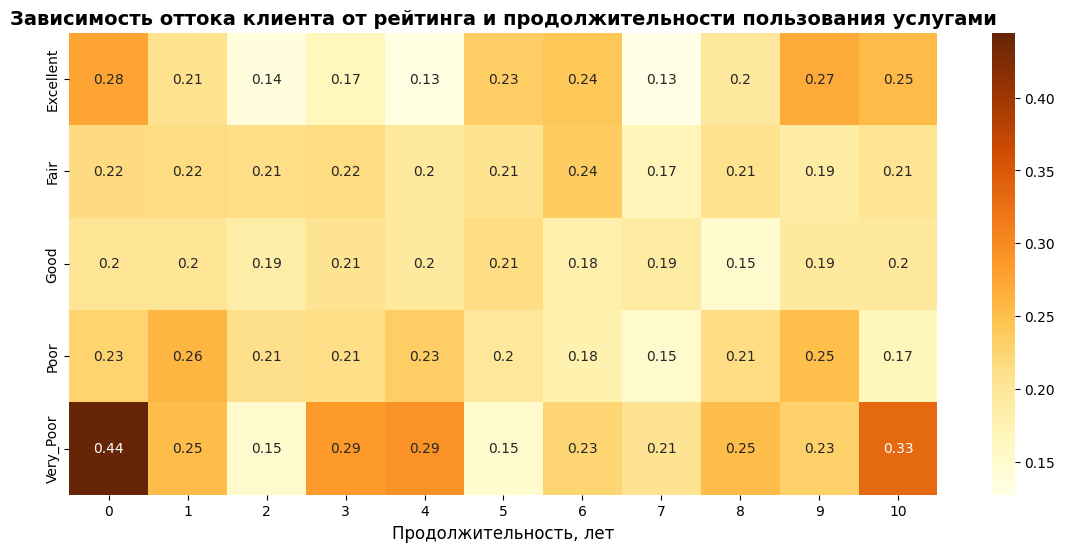

In [25]:
fig = plt.figure(figsize= (14,6))
ten_map = sns.heatmap(
    data= credit_score_pivot,
    annot= True,
    cmap= sns.color_palette("YlOrBr", as_cmap=True),
    
)
ten_map.set_ylabel(None)
ten_map.set_xlabel('Продолжительность, лет', fontsize= 12)
ten_map.set_title('Зависимость оттока клиента от рейтинга и продолжительности пользования услугами', 
                  fontweight= 'bold', 
                  fontsize= 14);


В соответствии с полученными данными видим, что больше всего отток клиентов (25% и более) наблюдается в категории граждан с __очень слабой кредитной историей__ и отличной кредитной историей.\
Стоит рассмотреть более привлекательные условия кредитования для удержания клиентов.\
Также стоит присмотреться к категории граждан с отличной кредитной историей 